# Lecture 08 - 18 October 2021

This lecture will be focusses on more examples and applications of the simulation theorem.

## Low pass filter (again)
\begin{align*}
    \tilde{G}(\omega) &= \frac{1}{1-i\omega \tau} \quad \tau=\frac{1}{RC}\\
    V(z)& =\frac{1-c}{2}\frac{z+1}{z-c} \qquad \text{with } c=\frac{1-T/2\tau}{1+T/2\tau} \\
\end{align*}

### Properties:
1. **Check reality**: as easy as checking $V^*(z^*)=V(z)$
2. **Check causality**: $\left( 0\not \in ROC; \infty\in ROC \right)$  
  The pole is in $\tilde{z}=c=\frac{1-T/2\tau}{1+T/2\tau}\simeq1-\epsilon$ which is inside $\Gamma_1$ and one can always find a path $\Gamma$ such that $\tilde{z}\ um\ \Gamma \subset \Gamma_1$.
![Poles inside Gamma 1](images/21-10-18_ROC.jpeg)
3. **Bibo stability**: checked in the same way as causality
4. Behaviour at $\omega=\pm \frac{\pi}{T}$: fine due to backwrds interpretation of the simulation theorem.
\begin{align*}
\tilde{H}(\omega)= V\left( z=e^{-i\omega T}\right)= \left. \frac{1-c}{2}\frac{e^{-i\omega T}+1}{e^{-i\omega T}+c} \right|_{\omega=\pm\frac{\pi}{T}}=0
\end{align*}
5. **Bode diagram**:
\begin{align*}
\left| V(z)\right| &= \frac{1-c}{2}\sqrt{\frac{2[1+\cos(\omega T)]}{1+c^2-2c \cos(\omega T)}} = \frac{\left| \cos(\frac{\omega T}{2}) \right|}{\sqrt{1+\frac{4c}{(1-c)^2} \sin^2\left(\frac{\omega T}{2}\right)}} \\
G_{3dB} &= 20Log_{10}\left( \tilde{H}(\omega)\right)\\
\end{align*}
with $\omega$ in the Nyquist band $\left[ -\frac{\pi}{T};\frac{\pi}{T} \right]$. By further assuming $\omega<<\frac{1}{T}$  it is possible to write:

\begin{align*}
\left| \tilde{H}(\omega << \frac{1}{T}) \right|^2  &\simeq \frac{1-(\omega T)^2/8}{1+\frac{4c}{1-c}\frac{\omega^2 T^2}{4}} \\
&= \left[ 1-\frac{(\omega T)}{8} \right] \frac{1}{1+\frac{1}{\frac{(1-c)^2}{2}\frac{1}{T^2}}} \xrightarrow[\text{of the Low Pass}]{\text{canonical form}} \frac{1}{1+\tau^2 s^2}\\
\omega_{3dB}&=\frac{1-c}{\sqrt{c}}\frac{1}{T}\simeq \frac{\epsilon}{T}
\end{align*}

6. **Difference equation**
\begin{align*}
    V(z)&=\frac{Y(z)}{X(z)}= \frac{1-c}{2}\frac{z+1}{z-c} \implies y(z)\left( 1-\frac{c}{z}\right)=\frac{1-c}{2}\left( 1+\frac{1}{z}\right) x(z)\\
    &\implies y[n]c-y[n-1]=\frac{1-c}{2}(x[n]+x[n-1]) \quad \text{Time domain}
\end{align*}

The difference equation $y[n]=y[n-1](1-2^{-k})+2^{-(k+1)}(x[n]+x[n-1])$ can be easily implemented on an FPGA by assuming $1-c=\epsilon=2^{-k}$:
```Verilog Code
y[n]=y[n-1]-(y[n-1]>>k)+ (x[n]+x[n-1])>>(k+1)
```

Let's suppose a $50 Hz$ filter is needed. Instead of using the simulation theorem applied to a _notch filter_ it is possible to obtainan an equivalent relation working by steps. First a zero at $50 Hz$ is needed. But a single zero is not sufficient because reality requires $V^*(z^*)=V(z)$. Then at least two more poles are necessaries to assure convergence but a pole at precisely $50 Hz$ violates causality as it lies on $\Gamma_1$. The solution to this problem is to consider an arbitrarly close point in the following way:
\begin{align*}
\require{color}
V(z) = \frac{\textcolor[rgb]{1.00,0.00,0.00}{(z-z_0)} \textcolor[rgb]{0.00,0.00,0.00}{(z-z_0^*)} }{\textcolor[rgb]{0.00,0.00,1.00}{(z-cz_0)(z-cz_0^*)}} \qquad c=1-\epsilon \simeq 1
\end{align*}
where:
- $\textcolor[rgb]{1.00,0.00,0.00}{(z-z_0)}$ suppress the unwanted frequency
- $\textcolor[rgb]{0.00,0.00,0.00}{(z-z_0)^*}$ forces reality $V^*(z^*)=V(z)$
- $\textcolor[rgb]{0.00,0.00,1.00}{(z-cz_0)(z-cz_0^*)}$ imposes causality $40\not \in ROC; \infty\subset ROC$. $c$ makes the width of the filter as small as possible. $ROC: \left\{z: \left|z\right|>c \right\}$.

!()[images/21-10-18_Notch_Filter.jpeg]

#### e.g. Filter at $f_0\frac{1}{4T}\rightarrow z_0 = \pm i$
\begin{align*}
V(z) &=\frac{(z-i)(z+i)}{(z-ci)(z+ci)} = \frac{z^2+1}{z^2-c^2} = \frac{e^{-2i\omega T}+1}{e^{-2i\omega T}+c^2}\\
&=\sqrt{ \frac{2[1+\cos(2\omega T)]}{1+c^2+2c^2 \cos(2\omega T)}} = \frac{\left|\cos(\omega T)\right|}{\sqrt{1-\left[ \frac{2c}{1+c^2}\sin(\omega T)\right]}}\frac{2}{1+c^2}
\end{align*}

Let's plot the results:

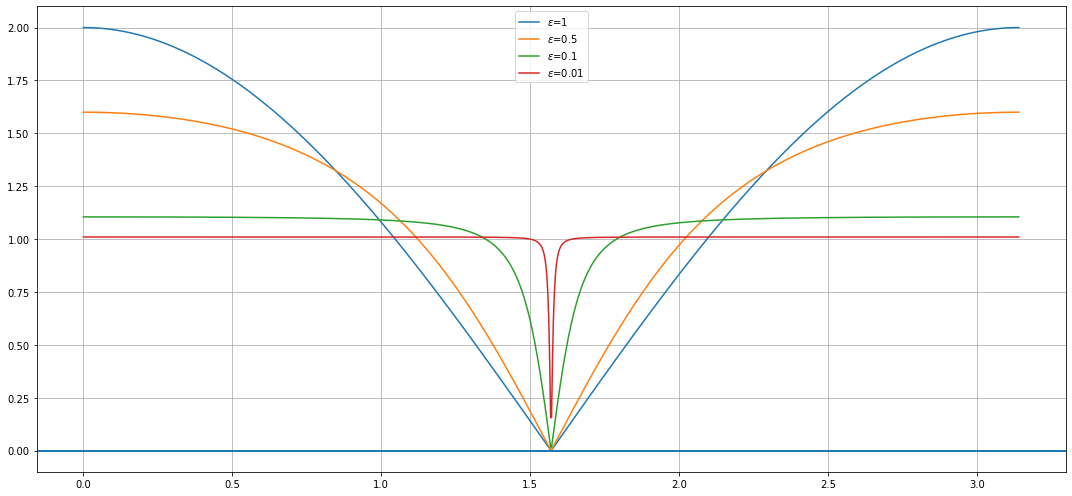

In [1]:
import matplotlib.pyplot as plt
import numpy as np

##############
# PARAMETERS #
##############
T=1#/1024 # Sampling time
f3dB = 1/(4*T) # Hz
omega = np.linspace(start=0, stop=np.pi/T, \
                    num=1000, endpoint=True)

def notch(omega, epsilon):
    c = 1-epsilon
    num = 2/(1+c**2)*np.abs(np.cos(omega*T))
    den = (np.sqrt(1-np.power(2*c/(1+c**2)*np.sin(omega*T),2) )) 
    
    return num/den

#########
# PLOTS #
#########
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

for epsilon in [1, 0.5, 0.1, 0.01]:
    V = notch(omega, epsilon); #V = 20*np.log10(V);
    ax.plot(omega, V, label=r"$\epsilon$={:}".format(epsilon))
    ax.axhline(y=0, xmin=0, xmax=1)

ax.grid()
ax.legend()
fig.tight_layout()
plt.show()